# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
dataset = pd.read_csv('datos/diabetes.csv')

In [3]:
X = dataset.drop('Y', axis = 'columns')
Y = dataset['Y']

In [4]:
def backwards(X,Y):
    
    model = sm.OLS(Y,X)
    results = model.fit()
    current_aic = results.aic
    smallest_drop = ('',current_aic)
    dropped = False
    
    while(True):
        
        for col in X.columns:
            
            model = sm.OLS(Y,X.drop(col,axis=1))
            results = model.fit()
#             print(results.aic)
            if results.aic < smallest_drop[1]:
                smallest_drop = (col,results.aic)
                dropped = True
        
        if not dropped:
            return X
            break
        X = X.drop(smallest_drop[0],axis=1)
        dropped = False
            

In [5]:
def forward(X,Y):
    
    read = []
    dropped = False
    
    columns = list(X.columns)
    
    model = sm.OLS(Y,X[columns[0]])
    results = model.fit()
    smallest_drop = (columns[0],results.aic)
    
    for col in columns[1:]:
        
        model = sm.OLS(Y,X[col])
        results = model.fit()
        if results.aic < smallest_drop[1]:
            smallest_drop = (col,results.aic)
    
    read.append(smallest_drop[0])
    columns.remove(smallest_drop[0])
    
    
    while(True):
        
        for col in columns:
            
            if not col in read:
            
                to_read = read.copy()
                to_read.append(col)
                model = sm.OLS(Y,X[to_read])
                results = model.fit()
                if results.aic < smallest_drop[1]:
                    smallest_drop = (to_read,results.aic)
                    dropped = True
        
        if not dropped:
            return X[read]
            break
        read = smallest_drop[0].copy()
        dropped = False
                    

In [6]:
forw = forward(X,Y)
backw = backwards(X,Y)
print(forw.columns)
print(backw.columns)

Index(['bmi', 's5', 'bp'], dtype='object')
Index(['bmi', 'bp', 's5'], dtype='object')


In [7]:
selected_variables = list(backw.columns)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X[selected_variables],
                                               Y,
                                               test_size=0.3,
                                               random_state=69420)

lin_regression = LinearRegression()

lin_regression.fit(xtrain,ytrain)

prediction = lin_regression.predict(xtest)

print('Error cuadrado regresion lineal:',
      metrics.mean_squared_error(ytest,prediction))

Error cuadrado regresion lineal: 2985.9339916862828


In [10]:
def linreg_test_size_opt(X,Y):
    
    sizes = [0.2,0.25,0.3,0.35,0.4]
    errors = []
    model = LinearRegression()
    
    for size in sizes:
    
        xtrain, xtest, ytrain, ytest = train_test_split(X[selected_variables],
                                                   Y,
                                                   test_size=size,
                                                   random_state=69420)
        model.fit(xtrain,ytrain)
        prediction = model.predict(xtest)
        errors.append(metrics.mean_squared_error(ytest,prediction))

    return sizes[errors.index(min(errors))], min(errors)
    

In [11]:
selected_size, error = linreg_test_size_opt(X,Y)
print('--------Regresion Lineal--------')
print(f'Tamano de muestra de prueba: {selected_size}\nError cuadrado: {error}')

--------Regresion Lineal--------
Tamano de muestra de prueba: 0.35
Error cuadrado: 2877.9363071991634


In [12]:
#NN
xtrain, xtest, ytrain, ytest = train_test_split(X,
                                               Y,
                                               test_size=selected_size,
                                               random_state=69420)

feature_cols = [tf.feature_column.numeric_column(col) for col in X[selected_variables].columns]

train_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x = xtrain,
                                                 y = ytrain,
                                                 batch_size=10,
                                                 num_epochs=2000,
                                                 shuffle=True)

neurons = [2,4,8,16,32,64,128]
errors = []

for neuron in neurons:
    
    model = tf.estimator.DNNRegressor(hidden_units=[neuron],
                                     feature_columns=feature_cols)
    model.train(input_fn=train_input,steps=5000)
    
    test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                              batch_size=10,
                                                              num_epochs=1,
                                                              shuffle=False)
    
    tests = []
    
    for prediction in list(model.predict(test_input)):
        tests.append(prediction['predictions'])
    
    errors.append(metrics.mean_squared_error(tests,ytest))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmp5033ox53', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I

INFO:tensorflow:loss = 14535.401, step = 4000 (0.241 sec)
INFO:tensorflow:global_step/sec: 404.771
INFO:tensorflow:loss = 28640.62, step = 4100 (0.246 sec)
INFO:tensorflow:global_step/sec: 434.883
INFO:tensorflow:loss = 18257.193, step = 4200 (0.230 sec)
INFO:tensorflow:global_step/sec: 425.531
INFO:tensorflow:loss = 35453.188, step = 4300 (0.237 sec)
INFO:tensorflow:global_step/sec: 436.682
INFO:tensorflow:loss = 12212.939, step = 4400 (0.229 sec)
INFO:tensorflow:global_step/sec: 353.357
INFO:tensorflow:loss = 32129.703, step = 4500 (0.279 sec)
INFO:tensorflow:global_step/sec: 353.357
INFO:tensorflow:loss = 23169.738, step = 4600 (0.288 sec)
INFO:tensorflow:global_step/sec: 392.157
INFO:tensorflow:loss = 22493.262, step = 4700 (0.252 sec)
INFO:tensorflow:global_step/sec: 411.512
INFO:tensorflow:loss = 41002.02, step = 4800 (0.243 sec)
INFO:tensorflow:global_step/sec: 413.233
INFO:tensorflow:loss = 27984.8, step = 4900 (0.248 sec)
INFO:tensorflow:Saving checkpoints for 5000 into C:\Use

INFO:tensorflow:global_step/sec: 274.724
INFO:tensorflow:loss = 17755.303, step = 3300 (0.364 sec)
INFO:tensorflow:global_step/sec: 272.482
INFO:tensorflow:loss = 36771.81, step = 3400 (0.367 sec)
INFO:tensorflow:global_step/sec: 272.479
INFO:tensorflow:loss = 28826.291, step = 3500 (0.366 sec)
INFO:tensorflow:global_step/sec: 273.962
INFO:tensorflow:loss = 32922.21, step = 3600 (0.364 sec)
INFO:tensorflow:global_step/sec: 294.129
INFO:tensorflow:loss = 24046.59, step = 3700 (0.348 sec)
INFO:tensorflow:global_step/sec: 284.896
INFO:tensorflow:loss = 29189.297, step = 3800 (0.343 sec)
INFO:tensorflow:global_step/sec: 274.73
INFO:tensorflow:loss = 15087.639, step = 3900 (0.364 sec)
INFO:tensorflow:global_step/sec: 228.311
INFO:tensorflow:loss = 24013.73, step = 4000 (0.444 sec)
INFO:tensorflow:global_step/sec: 262.463
INFO:tensorflow:loss = 31308.91, step = 4100 (0.375 sec)
INFO:tensorflow:global_step/sec: 269.545
INFO:tensorflow:loss = 27391.037, step = 4200 (0.376 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 37793.543, step = 2800 (0.279 sec)
INFO:tensorflow:global_step/sec: 341.295
INFO:tensorflow:loss = 17643.111, step = 2900 (0.289 sec)
INFO:tensorflow:global_step/sec: 341.298
INFO:tensorflow:loss = 30599.02, step = 3000 (0.294 sec)
INFO:tensorflow:global_step/sec: 371.739
INFO:tensorflow:loss = 29013.963, step = 3100 (0.274 sec)
INFO:tensorflow:global_step/sec: 340.138
INFO:tensorflow:loss = 17382.04, step = 3200 (0.293 sec)
INFO:tensorflow:global_step/sec: 342.472
INFO:tensorflow:loss = 28078.963, step = 3300 (0.287 sec)
INFO:tensorflow:global_step/sec: 362.317
INFO:tensorflow:loss = 40803.03, step = 3400 (0.282 sec)
INFO:tensorflow:global_step/sec: 338.985
INFO:tensorflow:loss = 26173.559, step = 3500 (0.290 sec)
INFO:tensorflow:global_step/sec: 357.142
INFO:tensorflow:loss = 15181.725, step = 3600 (0.284 sec)
INFO:tensorflow:global_step/sec: 290.697
INFO:tensorflow:loss = 27839.791, step = 3700 (0.342 sec)
INFO:tensorflow:global_step/sec: 363.631
INFO:tensorfl

INFO:tensorflow:global_step/sec: 302.116
INFO:tensorflow:loss = 31622.818, step = 3000 (0.323 sec)
INFO:tensorflow:global_step/sec: 357.141
INFO:tensorflow:loss = 24617.684, step = 3100 (0.280 sec)
INFO:tensorflow:global_step/sec: 343.644
INFO:tensorflow:loss = 30343.531, step = 3200 (0.292 sec)
INFO:tensorflow:global_step/sec: 350.877
INFO:tensorflow:loss = 29203.432, step = 3300 (0.287 sec)
INFO:tensorflow:global_step/sec: 341.298
INFO:tensorflow:loss = 23628.848, step = 3400 (0.291 sec)
INFO:tensorflow:global_step/sec: 350.876
INFO:tensorflow:loss = 38506.477, step = 3500 (0.287 sec)
INFO:tensorflow:global_step/sec: 332.227
INFO:tensorflow:loss = 24017.135, step = 3600 (0.300 sec)
INFO:tensorflow:global_step/sec: 370.37
INFO:tensorflow:loss = 41750.0, step = 3700 (0.276 sec)
INFO:tensorflow:global_step/sec: 342.458
INFO:tensorflow:loss = 26038.05, step = 3800 (0.285 sec)
INFO:tensorflow:global_step/sec: 370.379
INFO:tensorflow:loss = 25638.41, step = 3900 (0.273 sec)
INFO:tensorflow

INFO:tensorflow:loss = 32816.656, step = 3100 (0.298 sec)
INFO:tensorflow:global_step/sec: 363.636
INFO:tensorflow:loss = 22148.69, step = 3200 (0.277 sec)
INFO:tensorflow:global_step/sec: 340.135
INFO:tensorflow:loss = 22098.916, step = 3300 (0.293 sec)
INFO:tensorflow:global_step/sec: 332.227
INFO:tensorflow:loss = 20369.238, step = 3400 (0.297 sec)
INFO:tensorflow:global_step/sec: 370.37
INFO:tensorflow:loss = 19257.303, step = 3500 (0.275 sec)
INFO:tensorflow:global_step/sec: 344.828
INFO:tensorflow:loss = 17597.35, step = 3600 (0.288 sec)
INFO:tensorflow:global_step/sec: 352.112
INFO:tensorflow:loss = 27491.188, step = 3700 (0.283 sec)
INFO:tensorflow:global_step/sec: 367.648
INFO:tensorflow:loss = 36168.69, step = 3800 (0.272 sec)
INFO:tensorflow:global_step/sec: 368.995
INFO:tensorflow:loss = 24640.168, step = 3900 (0.275 sec)
INFO:tensorflow:global_step/sec: 361.009
INFO:tensorflow:loss = 46331.242, step = 4000 (0.275 sec)
INFO:tensorflow:global_step/sec: 352.114
INFO:tensorflo

INFO:tensorflow:loss = 27962.178, step = 3200 (0.277 sec)
INFO:tensorflow:global_step/sec: 361.012
INFO:tensorflow:loss = 34191.645, step = 3300 (0.277 sec)
INFO:tensorflow:global_step/sec: 366.3
INFO:tensorflow:loss = 34440.29, step = 3400 (0.274 sec)
INFO:tensorflow:global_step/sec: 384.615
INFO:tensorflow:loss = 27959.225, step = 3500 (0.264 sec)
INFO:tensorflow:global_step/sec: 355.872
INFO:tensorflow:loss = 30169.021, step = 3600 (0.280 sec)
INFO:tensorflow:global_step/sec: 358.416
INFO:tensorflow:loss = 35532.844, step = 3700 (0.275 sec)
INFO:tensorflow:global_step/sec: 335.575
INFO:tensorflow:loss = 26452.416, step = 3800 (0.297 sec)
INFO:tensorflow:global_step/sec: 366.303
INFO:tensorflow:loss = 20464.379, step = 3900 (0.280 sec)
INFO:tensorflow:global_step/sec: 349.645
INFO:tensorflow:loss = 21316.992, step = 4000 (0.282 sec)
INFO:tensorflow:global_step/sec: 349.654
INFO:tensorflow:loss = 17404.629, step = 4100 (0.289 sec)
INFO:tensorflow:global_step/sec: 370.369
INFO:tensorfl

INFO:tensorflow:loss = 28000.332, step = 3300 (0.293 sec)
INFO:tensorflow:global_step/sec: 363.637
INFO:tensorflow:loss = 19913.562, step = 3400 (0.275 sec)
INFO:tensorflow:global_step/sec: 338.982
INFO:tensorflow:loss = 18486.16, step = 3500 (0.294 sec)
INFO:tensorflow:global_step/sec: 362.321
INFO:tensorflow:loss = 21026.234, step = 3600 (0.281 sec)
INFO:tensorflow:global_step/sec: 336.7
INFO:tensorflow:loss = 28620.941, step = 3700 (0.292 sec)
INFO:tensorflow:global_step/sec: 350.876
INFO:tensorflow:loss = 31438.738, step = 3800 (0.288 sec)
INFO:tensorflow:global_step/sec: 355.873
INFO:tensorflow:loss = 25672.043, step = 3900 (0.280 sec)
INFO:tensorflow:global_step/sec: 343.642
INFO:tensorflow:loss = 30184.691, step = 4000 (0.292 sec)
INFO:tensorflow:global_step/sec: 264.551
INFO:tensorflow:loss = 24390.035, step = 4100 (0.378 sec)
INFO:tensorflow:global_step/sec: 304.878
INFO:tensorflow:loss = 38436.523, step = 4200 (0.327 sec)
INFO:tensorflow:global_step/sec: 322.58
INFO:tensorflo

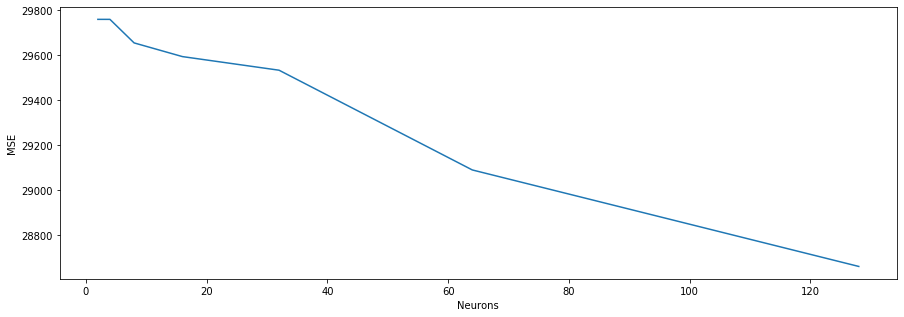

In [13]:
plt.figure(figsize=(15,5))
plt.xlabel('Neurons')
plt.ylabel("MSE")
plt.plot(neurons,errors)

In [14]:
neurons_per_layer=neurons[errors.index(min(errors))]
print(neurons_per_layer)

128


In [15]:
layers = [[128],
         [128,128],
         [128,128,128],
         [128,128,128,128],
         [128,128,128,128,128]]

errors_layers = []

for layer in layers:
    
    model = tf.estimator.DNNRegressor(hidden_units=layer,
                                     feature_columns = feature_cols)
    model.train(input_fn=train_input,steps=5000)
    
    test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                              batch_size=10,
                                                              num_epochs=1,
                                                              shuffle=False)
    
    predictions = []
    
    for predict in list(model.predict(test_input)):
        predictions.append(predict['predictions'])
    
    errors_layers.append(metrics.mean_squared_error(predictions,ytest))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpbon7gfug', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, y

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpb9cbmxvx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If 

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmppzc4fv5o\model.ckpt.
INFO:tensorflow:loss = 30226.094, step = 0
INFO:tensorflow:global_step/sec: 257.732
INFO:tensorflow:loss = 38624.254, step = 100 (0.390 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmpklydxkuy\model.ckpt.
INFO:tensorflow:loss = 23536.76, step = 0
INFO:tensorflow:global_step/sec: 194.553
INFO:tensorflow:loss = 21935.56, step = 100 (0.514 sec)
INFO:tensorflow:global_step/sec: 236.406
INFO:tensorflow:loss = 22844.693, step = 200 (0.426 sec)
INFO:tensorflow:global_step/sec: 250.623
INFO:tensorflow:loss = 5845.1895, step = 300 (0.396 sec)
INFO:tensorflow:global_step/sec: 251.893
INFO:tensorflow:loss = 4470.536, step = 400 (0.398 sec)
INFO:tensorflow:global_step/sec: 227.272
INFO:tensorflow:loss = 4220.368, step = 500 (0.442 sec)
INFO:tensorflow:global_step/sec: 251.256
INFO:tensorflow:loss = 6705.896, step = 600 (0.395 sec)
INFO:tensorflow:global_step/sec: 291.545
INFO:tensorflow:loss = 730

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmpf1hm3yf7\model.ckpt.
INFO:tensorflow:loss = 18033.795, step = 0
INFO:tensorflow:global_step/sec: 289.026
INFO:tensorflow:loss = 22551.408, step = 100 (0.346 sec)
INFO:tensorflow:global_step/sec: 381.679
INFO:tensorflow:loss = 5606.9893, step = 200 (0.261 sec)
INFO:tensorflow:global_step/sec: 375.94
INFO:tensorflow:loss = 2567.2866, step = 300 (0.267 sec)
INFO:tensorflow:global_step/sec: 380.229
INFO:tensorflow:loss = 1525.4523, step = 400 (0.262 sec)
INFO:tensorflow:global_step/sec: 380.228
INFO:tensorflow:loss = 6207.1084, step = 500 (0.264 sec)
INFO:tensorflow:global_step/sec: 380.228
INFO:tensorflow:loss = 2472.7866, step = 600 (0.263 sec)
INFO:tensorflow:global_step/sec: 377.358
INFO:tensorflow:loss = 5658.781, step = 700 (0.265 sec)
INFO:tensorflow:global_step/sec: 380.228
INFO:tensorflow:loss = 4312.218, step = 800 (

In [16]:
model_layers = layers[errors_layers.index(min(errors_layers))]

In [17]:
final_errors = []

model = tf.estimator.DNNRegressor(hidden_units=model_layers,
                                 feature_columns=feature_cols)
model.train(input_fn=train_input,steps=5000)
test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                          batch_size=10,
                                                          num_epochs=1,
                                                          shuffle=False)
predictions = []
    
for predict in list(model.predict(test_input)):
    predictions.append(predict['predictions'])

final_errors.append(metrics.mean_squared_error(predictions,ytest))    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmp3c_rog7c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, y

In [18]:
print(f'MSE para red 128 neuronas por capa, 5 capas:\n{final_errors}')

MSE para red 128 neuronas por capa, 5 capas:
[2845.137723379451]


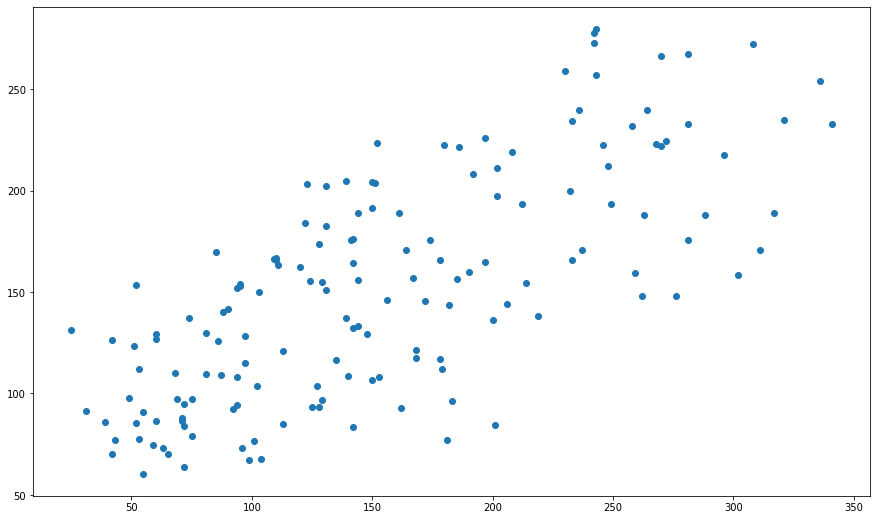

In [19]:
plt.figure(figsize=(15,9))
plt.scatter(ytest,predictions)

In [20]:
from sklearn.model_selection import KFold

def x_validation(train_index,test_index,X,Y):
    
    xtrain = X.iloc[train_index,:]
    xtest = X.iloc[test_index,:]
    ytrain = Y.iloc[train_index]
    ytest = Y.iloc[test_index]
    
    train_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtrain,
                                                               y=ytrain,
                                                               batch_size=10,
                                                               num_epochs=2000,
                                                               shuffle=True)
    
    model = tf.estimator.DNNRegressor(hidden_units=model_layers,
                                     feature_columns=feature_cols)
    model.train(input_fn=train_input,steps=5000)
    
    test_input = tf.compat.v1.estimator.inputs.pandas_input_fn(x=xtest,
                                                              batch_size=10,
                                                              num_epochs=1,
                                                              shuffle=False)
    predictions = []
    
    for predict in list(model.predict(test_input)):
        predictions.append(predict['predictions'])
    
    return metrics.mean_squared_error(predictions,ytest)
    
kf = KFold(n_splits=4)

x_val = []

for train_index,test_index in kf.split(X):
    x_val.append(x_validation(train_index,test_index,X[selected_variables],Y))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmpyuho23ba', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, y

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Mirai\\AppData\\Local\\Temp\\tmp64qbwdy9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If 

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmp2v5qywfq\model.ckpt.
INFO:tensorflow:loss = 23147.742, step = 0
INFO:tensorflow:global_step/sec: 331.69
INFO:tensorflow:loss = 7059.831, step = 100 (0.300 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Mirai\AppData\Local\Temp\tmpxvgh0614\model.ckpt.
INFO:tensorflow:loss = 30668.676, step = 0
INFO:tensorflow:global_step/sec: 267.379
INFO:tensorflow:loss = 28873.184, step = 100 (0.374 sec)
INFO:tensorflow:global_step/sec: 364.965
INFO:tensorflow:loss = 6201.215, step = 200 (0.272 sec)
INFO:tensorflow:global_step/sec: 409.835
INFO:tensorflow:loss = 4233.58, step = 300 (0.244 sec)
INFO:tensorflow:global_step/sec: 460.825
INFO:tensorflow:loss = 3921.5593, step = 400 (0.218 sec)
INFO:tensorflow:global_step/sec: 471.702
INFO:tensorflow:loss = 3408.625, step = 500 (0.215 sec)
INFO:tensorflow:global_step/sec: 413.222
INFO:tensorflow:loss = 4165.598, step = 600 (0.238 sec)
INFO:tensorflow:global_step/sec: 462.965
INFO:tensorflow:loss = 492

In [21]:
print(f'Cross Validation MSE: {sum(x_val)/len(x_val)}')

Cross Validation MSE: 3094.4275453870946
